# Severity Classification Models for Traffic Accidents
In this notebook, Feedforward Neural Networks to predict the severity of traffic crashes will be developed.

In [1]:
# This cell should be run when this notebook is excuted on Google Colab.
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Mounted at /content/drive
/content/drive/My Drive/Capstone


In [2]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import *

## Read Dataset
Load the oversampled data

In [4]:
# Read the data
df_train = pd.concat([pd.read_csv(f"Data/train_smote_{i}.csv") for i in range(1, 5)], ignore_index=True)
df_val = pd.read_csv("Data/val.csv", index_col=False)
df_test = pd.read_csv("Data/test.csv", index_col=False)

### Model Development - FNN

Encoding the categorical features

In [5]:
df_train = df_train.sample(frac=1, random_state=6501).reset_index(drop=True)

In [6]:
df_train_x = df_train.drop(columns=["Severity"])
y_train = df_train["Severity"].values - 1

df_val_x = df_val.drop(columns=["Severity"])
y_val = df_val["Severity"].values - 1

df_test_x = df_test.drop(columns=["Severity"])
y_test = df_test["Severity"].values - 1

In [7]:
# Concat feature matrics
df_X = pd.concat([df_train_x, df_val_x, df_test_x], sort=False)

#### Encoding cyclic categorical features
* "CRASH_DATE_month", "CRASH_DATE_hour", and "CRASH_DAY_OF_WEEK" are categorical, but also are cyclical.
* Encoding these feature by One-Hot encoding (OHE) will lead to the increase of the demension, which is not prefereable. In addition, the OHE cannot capture the cyclic characteristic in these features. Therefore, encoding utilized trigonometric functions will be applied.

In [8]:
df_X = cyclic_encoding(df_X, ["CRASH_DATE_month", "CRASH_DATE_hour", "CRASH_DAY_OF_WEEK"])

#### Encoding other catogorical features
* Encoding other categorical features than cyclic ones by OHE

In [9]:
df_X = df_X.astype({"POSTED_SPEED_LIMIT": float, "NUM_UNITS": float, "LATITUDE": float, "LONGITUDE": float})

In [10]:
df_X = pd.get_dummies(df_X, drop_first=True)

In [11]:
df_train_x = df_X.iloc[:df_train_x.shape[0], :]
df_val_x = df_X.iloc[df_train_x.shape[0] : df_train_x.shape[0] + df_val_x.shape[0], :]
df_test_x = df_X.iloc[df_train_x.shape[0] + df_val_x.shape[0]:, :]

### Constructing model

In [12]:
X_train = df_train_x.values
X_val = df_val_x.values
X_test = df_test_x.values

In [20]:
# A sequential dnn
model = keras.models.Sequential()

# Add the first hidden layer
model.add(keras.layers.Dense(171, activation='relu', input_shape=(X_train.shape[1], )))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the second hidden layer
model.add(keras.layers.Dense(85, activation='relu'))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the second hidden layer
model.add(keras.layers.Dense(40, activation='relu'))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the output layer
model.add(keras.layers.Dense(3, activation='softmax'))

# The model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 171)               19665     
                                                                 
 batch_normalization_2 (Bat  (None, 171)               684       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 85)                14620     
                                                                 
 batch_normalization_3 (Bat  (None, 85)                340       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 40)                3440      
                                                                 
 batch_normalization_4 (Bat  (None, 40)               

In [21]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3)

In [22]:
# Train, evaluate and save the best model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    #validation_split=0.2,
                    callbacks=[early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/50
29692/29692 [==============================] - 104s 3ms/step - loss: 0.7289 - accuracy: 0.6733 - val_loss: 0.7183 - val_accuracy: 0.6624 - lr: 0.0010
Epoch 2/50
29692/29692 [==============================] - 99s 3ms/step - loss: 0.6599 - accuracy: 0.7120 - val_loss: 0.6779 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 3/50
29692/29692 [==============================] - 95s 3ms/step - loss: 0.6326 - accuracy: 0.7259 - val_loss: 0.7044 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 4/50
29692/29692 [==============================] - 89s 3ms/step - loss: 0.6168 - accuracy: 0.7341 - val_loss: 0.7133 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 5/50
29692/29692 [==============================] - 97s 3ms/step - loss: 0.6050 - accuracy: 0.7398 - val_loss: 0.7064 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 6/50
29692/29692 [==============================] - 91s 3ms/step - loss: 0.5740 - accuracy: 0.7546 - val_loss: 0.6881 - val_accuracy: 0.6832 - lr: 1.0000e-04
Epoch 7/50
29692/29692 [===========

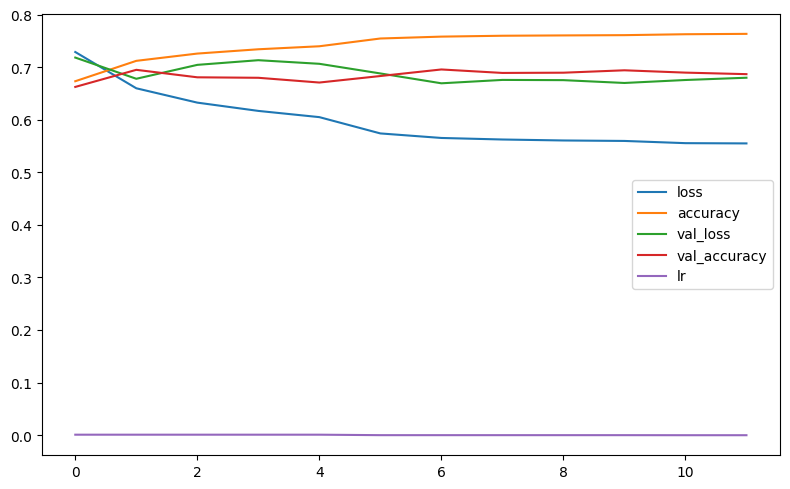

In [23]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

3859/3859 [==============================] - 7s 2ms/step
Accuracy: 0.6934769405190914
Precision: 0.409074148925099
Recall: 0.477497230638843
F1 Score: 0.40862386771227927
